In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
import glob
from matplotlib.dates import DateFormatter


stn01


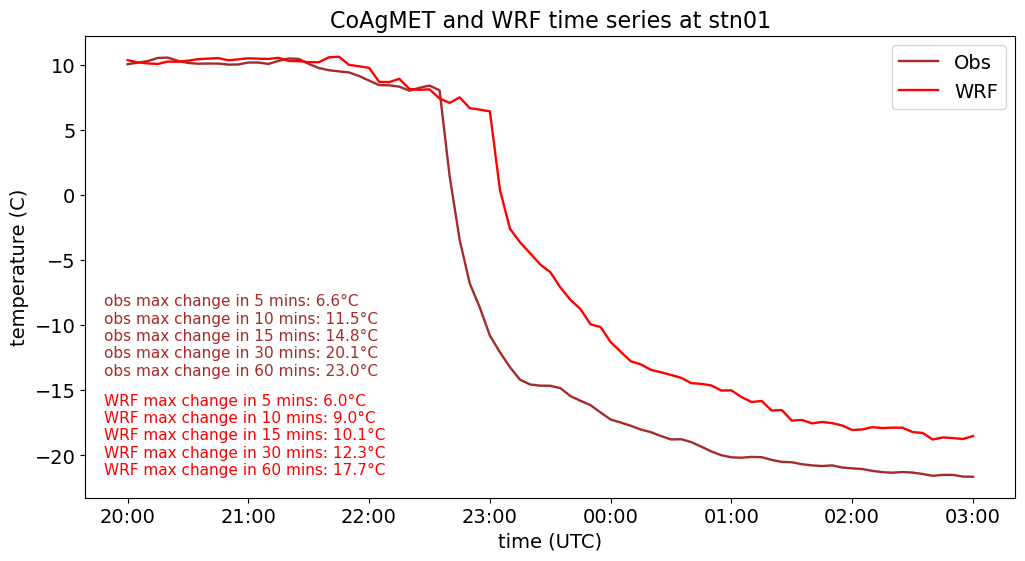

In [6]:
###### get list of stations and loop over them:
### get list of WRF TS files
#tslist = glob.glob("tser/*.d02.TS")
tslist = ["tser/stn01.d02.TS"]

### WRF init time
init=pd.Timestamp(2022,12,21,18)
end = pd.Timestamp(2022,12,22,5)
timestep = 3  ### in seconds

for tsfile in tslist:
    
    loc = tsfile.split("/")[1].split(".")[0].lower()  ### should be the station ID
    print(loc)
    
    try:

        data = pd.read_fwf("tser/"+loc+".d02.TS", skiprows=1, header=None, infer_nrows=50000)
        #data = pd.read_fwf("/glade/scratch/rschumac/WRFV4/run/thomps_3dom_noah/sedg.d03.TS", skiprows=1, header=None)

        data.columns=['domain','time','tsid','ix','iy','t2k','qv','u10','v10','psfc','glw','gsw','hfx','lh','tsk','tslb','rainc','rainnc','clw']

        data['wspd'] = (data['u10']**2+data['v10']**2)**(0.5)
        data['t2c'] = data['t2k'] - 273.15

        #data['datetime'] = (init + pd.TimedeltaIndex(data['time'], unit='H')).tz_localize("UTC")
        ### or because the timestamps in the file get rounded off which causes problems, just set it to the right frequency:
        timestep_str = str(timestep)+"S"
        data['datetime'] = pd.date_range((init+pd.Timedelta(seconds=timestep)),end,freq=timestep_str).tz_localize("UTC")

        data.set_index('datetime', inplace=True)

        ### subset down in time
        data = data['2022-12-21 20:00':'2022-12-22 03:00']
        
        ### optional - subsample the WRF output to match the observations
        ### here that is every 100th timestep
        #data = data[::100]
        data = data.asfreq('5min')

        ### set a multi-index to allow for stacking/unstacking
        data.set_index([data.index,"domain"],inplace=True)

        ### calculate shifts

        ### note that timesteps don't exactly match up at 10 and 20 minutes; use the fractions of hours instead
        data['shifted_5min'] = data.unstack().shift(5, freq='min').stack()['t2k']
        data['shifted_10min'] = data.unstack().shift(10, freq='min').stack()['t2k']
        data['shifted_15min'] = data.unstack().shift(15, freq='min').stack()['t2k']
        data['shifted_20min'] = data.unstack().shift(20, freq='min').stack()['t2k']
        data['shifted_30min'] = data.unstack().shift(30, freq='min').stack()['t2k']
        data['shifted_60min'] = data.unstack().shift(60, freq='min').stack()['t2k']
        data['shifted_120min'] = data.unstack().shift(120, freq='min').stack()['t2k']
        data['shifted_180min'] = data.unstack().shift(180, freq='min').stack()['t2k']

        data['Tchange_5min'] = data['shifted_5min'] - data['t2k']
        data['Tchange_10min'] = data['shifted_10min'] - data['t2k']
        data['Tchange_15min'] = data['shifted_15min'] - data['t2k']
        data['Tchange_20min'] = data['shifted_20min'] - data['t2k']
        data['Tchange_30min'] = data['shifted_30min'] - data['t2k']
        data['Tchange_60min'] = data['shifted_60min'] - data['t2k']
        data['Tchange_120min'] = data['shifted_120min'] - data['t2k']
        data['Tchange_180min'] = data['shifted_180min'] - data['t2k']

        ### and reset index
        data = data.reset_index().set_index('datetime')

        ### CoAgMET data
        coag = pd.read_csv("https://coagmet.colostate.edu/data/5min/"+loc+".csv?header=yes&from=2022-12-21&tz=utc&units=m",
                          skiprows=[1], parse_dates=['Date and Time'])

        coag['datetime'] = coag['Date and Time'].dt.tz_localize("UTC")
        coag.set_index("datetime", inplace=True)

        ### subset down to same time as the WRF output
        coag = coag['2022-12-21 20:00':'2022-12-22 03:00']

        ### set -999's to nan
        coag.replace(-999, np.nan, inplace=True)

        ### set a multi-index to allow for stacking/unstacking
        coag.set_index([coag.index,"Station"],inplace=True)

        ### calculate shifts

        coag['shifted_5min'] = coag.unstack().shift(5, freq='min').stack()['Air Temp']
        coag['shifted_10min'] = coag.unstack().shift(10, freq='min').stack()['Air Temp']
        coag['shifted_15min'] = coag.unstack().shift(15, freq='min').stack()['Air Temp']
        coag['shifted_20min'] = coag.unstack().shift(20, freq='min').stack()['Air Temp']
        coag['shifted_30min'] = coag.unstack().shift(30, freq='min').stack()['Air Temp']
        coag['shifted_60min'] = coag.unstack().shift(60, freq='min').stack()['Air Temp']
        coag['shifted_120min'] = coag.unstack().shift(120, freq='min').stack()['Air Temp']
        coag['shifted_180min'] = coag.unstack().shift(180, freq='min').stack()['Air Temp']

        coag['Tchange_5min'] = coag['shifted_5min'] - coag['Air Temp']
        coag['Tchange_10min'] = coag['shifted_10min'] - coag['Air Temp']
        coag['Tchange_15min'] = coag['shifted_15min'] - coag['Air Temp']
        coag['Tchange_20min'] = coag['shifted_20min'] - coag['Air Temp']
        coag['Tchange_30min'] = coag['shifted_30min'] - coag['Air Temp']
        coag['Tchange_60min'] = coag['shifted_60min'] - coag['Air Temp']
        coag['Tchange_120min'] = coag['shifted_120min'] - coag['Air Temp']
        coag['Tchange_180min'] = coag['shifted_180min'] - coag['Air Temp']

        ### and reset index
        coag = coag.reset_index().set_index('datetime')

        ### and matplotlib plot

        fig, ax = plt.subplots(figsize=(12,6))

        ax.plot(coag.index,coag['Air Temp'], label='Obs', color='brown', lw=1.7)
        ax.plot(data.index,data['t2c'], label='WRF', color='red', lw=1.7)

        ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
        ax.set_xlabel("time (UTC)", fontsize=14)
        ax.set_ylabel("temperature (C)", fontsize=14)
        ax.tick_params(axis='both', labelsize=14)

        plt.title("CoAgMET and WRF time series at "+loc, fontsize=16)
        ax.legend(fontsize=14)

        ### add text annotation with the largest temperature drops
        ax.text(0.02,0.265,"obs max change in 5 mins: "+str(np.round(coag['Tchange_5min'].max(),1))+"°C\nobs max change in 10 mins: "+str(np.round(coag['Tchange_10min'].max(),1))+"°C\nobs max change in 15 mins: "+str(np.round(coag['Tchange_15min'].max(),1))+"°C\nobs max change in 30 mins: "+str(np.round(coag['Tchange_30min'].max(),1))+"°C\nobs max change in 60 mins: "+str(np.round(coag['Tchange_60min'].max(),1))+"°C",
                color='brown',fontsize=11,
               transform=ax.transAxes)
        ### add text annotation with the largest temperature drops
        ax.text(0.02,0.05,"WRF max change in 5 mins: "+str(np.round(data['Tchange_5min'].max(),1))+"°C\nWRF max change in 10 mins: "+str(np.round(data['Tchange_10min'].max(),1))+"°C\nWRF max change in 15 mins: "+str(np.round(data['Tchange_15min'].max(),1))+"°C\nWRF max change in 30 mins: "+str(np.round(data['Tchange_30min'].max(),1))+"°C\nWRF max change in 60 mins: "+str(np.round(data['Tchange_60min'].max(),1))+"°C",
                color='red',fontsize=11,
               transform=ax.transAxes)

        fig.savefig("wrf_coagmet_tser_compare_"+loc+".pdf", dpi=255, 
                    bbox_inches='tight', transparent=False, facecolor='white')

        plt.show()

        plt.close('all')

    except:
        print("plotting for "+loc+" failed")

    

